In [18]:
# import os
# os.chdir('/home/hugo-dev/esirem-dev/4a/kmutt/kmutt_v2')

In [19]:
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from utils.load_data import load_data_with_mapping
from glob import glob

In [20]:
DATA_PATH = './'

In [21]:
CLASSES = ["RMT", "DPR", "HRK"]
OVERLAP_DURATION = 50   # overlap duration in % (0 means no overlap)

DATA_PATH = "data/data_25ms_h=" + str(OVERLAP_DURATION) + "%_16mfcc_"

for classname in CLASSES:
    DATA_PATH += classname
    if classname != CLASSES[len(CLASSES) - 1]:
        DATA_PATH += "-"
DATA_PATH += ".json"

print(DATA_PATH)



data/data_25ms_h=50%_16mfcc_RMT-DPR-HRK.json


In [22]:
X, y, mapping = load_data_with_mapping(DATA_PATH)

print(X.shape)
print(y.shape)

Training sets loaded!
(560121, 1, 16)
(560121,)


In [23]:
label_mapping_3_classes = {0: "RMT", 1: "DPR", 2: "HRK"}
label_mapping_2_classes_rmt_hrk = {0: "RMT", 1: "HRK"}
label_mapping_2_classes_rmt_dpr_hrk = {0: "RMT", 1: "DPR+HRK"}
label_mapping_2_classes_dpr_hrk = {0: "DPR", 1: "HRK"}
label_mapping_2_classes_rmt_dpr = {0: "RMT", 1: "DPR"}

In [24]:
print(label_mapping_2_classes_rmt_dpr_hrk)

{0: 'RMT', 1: 'DPR+HRK'}


In [25]:
def plot_segments(y, label_mapping):
    plt.figure(figsize=(10, 5))
    values, counts = np.unique(y, return_counts=True)
    print(values, counts)

    # Mapping the labels dynamically
    mapped_labels = [label_mapping[val] for val in values]

    plt.bar(mapped_labels, counts)
    plt.xlabel('Classes')
    plt.ylabel('Total Segments')
    plt.title('Total Segments for each class')
    plt.show()

[0 1 2] [162460 174204 223457]


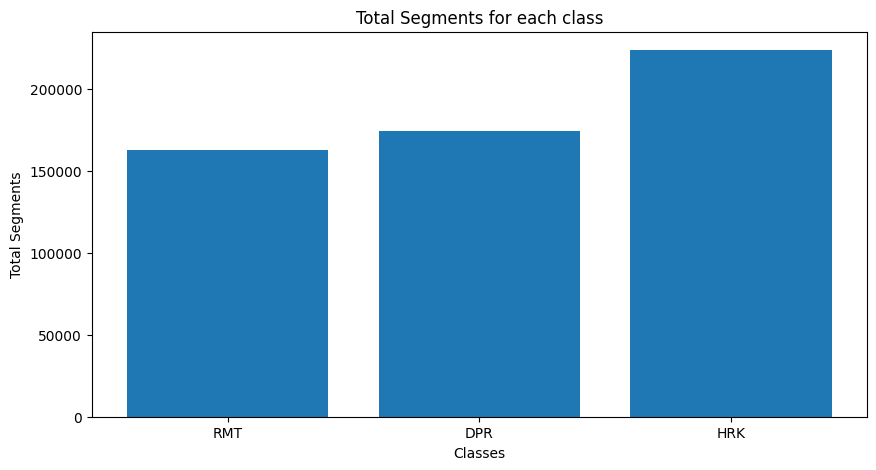

In [26]:
plot_segments(y, label_mapping_3_classes)

In [27]:
def calculate_f_ratios(mfcc_data, labels):
    f_ratios = []
    n_mfcc = mfcc_data.shape[2]  # 16 MFCCs

    for i in range(n_mfcc):
        class_data = [mfcc_data[labels == label, 0, i] for label in np.unique(labels)]

        f_val, p_val = f_oneway(*class_data)
        f_ratios.append(f_val)

    return f_ratios

In [28]:
def get_top_3_coefficients(f_ratios):
    return np.argsort(f_ratios)[-3:]

In [29]:
def plot_3d_interactive(mfcc_data, labels, top_3_indices, label_mapping):
    x = mfcc_data[:, 0, top_3_indices[0]]
    y = mfcc_data[:, 0, top_3_indices[1]]
    z = mfcc_data[:, 0, top_3_indices[2]]

    # Dynamically map the labels
    labels = [label_mapping[label] for label in labels]

    df = pd.DataFrame({
        f'MFCC {top_3_indices[0] + 1}': x,
        f'MFCC {top_3_indices[1] + 1}': y,
        f'MFCC {top_3_indices[2] + 1}': z,
        'Class': labels
    })

    fig = px.scatter_3d(df,
                        x=f'MFCC {top_3_indices[0] + 1}',
                        y=f'MFCC {top_3_indices[1] + 1}',
                        z=f'MFCC {top_3_indices[2] + 1}',
                        color='Class',
                        title='3D Scatter Plot of Top 3 MFCC')

    fig.write_html("top3-MFCC_plot.html")
    print("DONE")

In [30]:
f_ratios = calculate_f_ratios(X, y)
print(f_ratios)

[109786.07943874452, 23509.957704195378, 15688.644285879876, 1738.9258264016235, 18167.99192726018, 2016.397239530606, 1750.735777305538, 2464.855353646345, 3037.9319258728437, 12904.012612899636, 4471.317370186403, 7940.213101172895, 3773.516278114187, 14544.67395087952, 4415.096769334031, 2301.7102655050876]


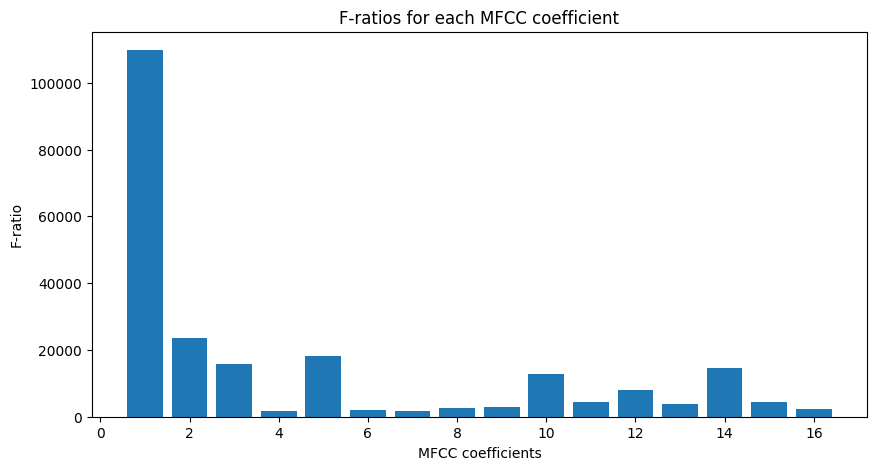

In [31]:
# draw the F-ratios
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(1, 17), f_ratios)
plt.xlabel("MFCC coefficients")
plt.ylabel("F-ratio")
plt.title("F-ratios for each MFCC coefficient")
plt.show()

In [32]:
# rank the F-ratios
sorted_indices = np.argsort(f_ratios)[::-1]
print(sorted_indices)

[ 0  1  4  2 13  9 11 10 14 12  8  7 15  5  6  3]


In [33]:
def get_first_n_samples_per_class(X, y, n_samples):
    unique_classes = np.unique(y)
    selected_indices = []

    for cls in unique_classes:
        # Indices des échantillons de la classe actuelle
        cls_indices = np.where(y == cls)[0]
        # Sélectionner les premiers 'n_samples' indices, si disponibles
        if len(cls_indices) >= n_samples:
            selected_indices.extend(cls_indices[:n_samples])
        else:
            selected_indices.extend(cls_indices)

    # Créer des sous-ensembles des données en utilisant les indices sélectionnés
    X_selected = X[selected_indices]
    y_selected = y[selected_indices]

    # Affichage pour vérifier les counts
    values, counts = np.unique(y_selected, return_counts=True)
    print(f"Selected counts per class: {dict(zip(values, counts))}")

    return X_selected, y_selected

# Exemple d'utilisation
top_3_indices = get_top_3_coefficients(f_ratios)

# Supposons que X et y sont vos données et labels
X_selected, y_selected = get_first_n_samples_per_class(X, y, 1000)

# Tracer le graphique avec les échantillons sélectionnés
# plot_3d_interactive(X_selected, y_selected, top_3_indices, label_mapping_3_classes)

Selected counts per class: {0: 1000, 1: 1000, 2: 1000}


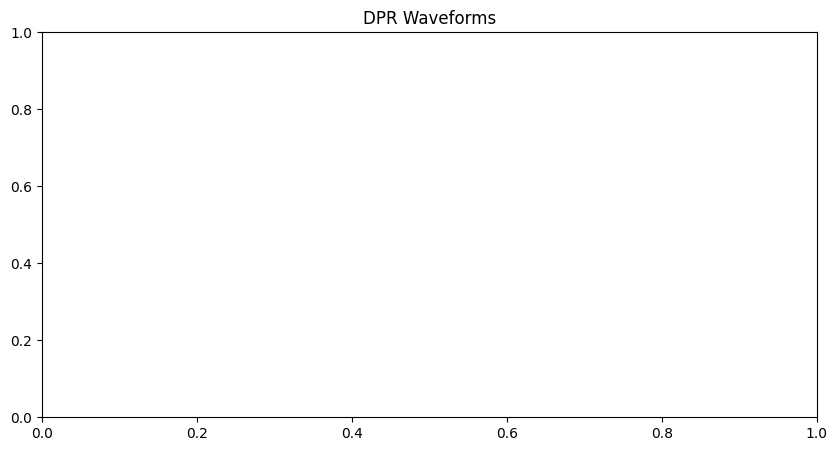

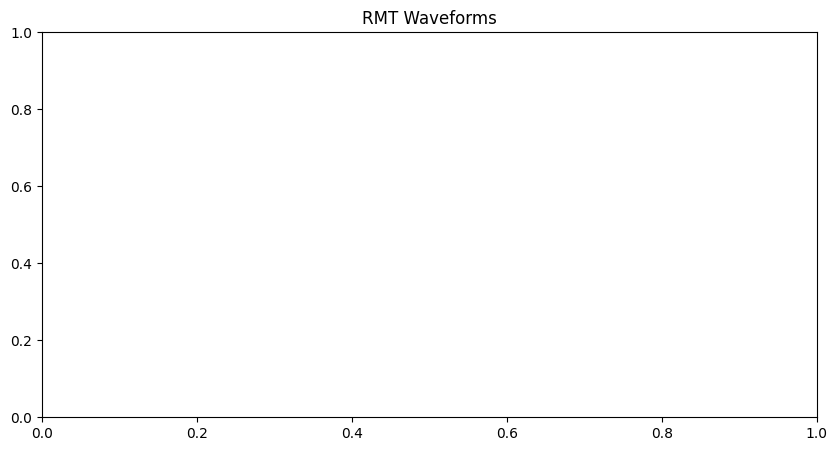

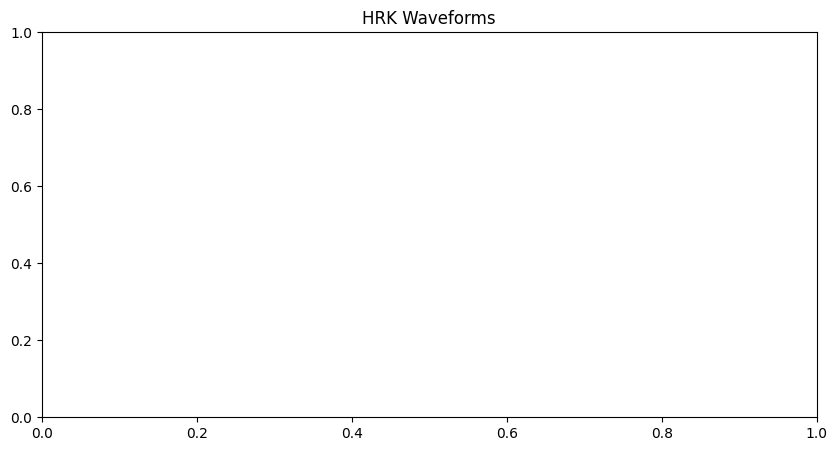

In [34]:
# DATA_PATH += '/Users/hugog/hugo-dev/esirem-dev/4a/kmutt/kmutt_intership_project_v2/data/orignal_dataset/'

DPR_audios_files=glob('/Users/hugog/hugo-dev/esirem-dev/4a/kmutt/kmutt_intership_project_v2/data/original_dataset/DPR/011106nt1_intvoc.wav')
RMT_audios_files=glob('/Users/hugog/hugo-dev/esirem-dev/4a/kmutt/kmutt_intership_project_v2/data/original_dataset/RMT/011706nt1_intvoc.wav')
HRK_audios_files=glob('/Users/hugog/hugo-dev/esirem-dev/4a/kmutt/kmutt_intership_project_v2/data/original_dataset/HRK/020806nt1_intvoc.wav')

# only plot the first 25ms of the audio
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_waveform(audio_files, title):
    plt.figure(figsize=(10, 5))
    for audio_file in audio_files:
        y, sr = librosa.load(audio_file, duration=0.012)
        librosa.display.waveshow(y, sr=10000)
    plt.title(title)
    plt.show()

plot_waveform(DPR_audios_files, 'DPR Waveforms')
plot_waveform(RMT_audios_files, 'RMT Waveforms')
plot_waveform(HRK_audios_files, 'HRK Waveforms')
